In [1]:
%load_ext autoreload
%autoreload 2
import torch
import pickle as pkl
import pickle5 as pkl5
from copy import deepcopy
import os
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import seaborn as sns
from scipy import io
import numpy as np
from sklearn.decomposition import PCA
#sys.path.insert(0, '/path/to/rave')

from rave.model.architectures import Autoencoder, CustomDataParallel
from rave.model.utils import ModelOutputs
from rave.model.training import train_model
from rave.evaluation.utils import print_result_dictionary, get_sim_ground_truth_labels
from rave.evaluation.score import get_all_scores
from rave.evaluation.embed import get_embedding
from rave.evaluation.visualize import visualize_embedding_basic

# Define paths

In [2]:
your_path_to_model_directory = ...
your_path_to_params_file = os.path.join(your_path_to_model_directory, 'params.pkl')

In [3]:
your_data_directory = ...
your_dataset_file_name = "sim_dataset.pkl"

In [4]:
ipl_file1=r'.../ipl.mat'
ipl_file2=r'.../BC_Profiles_Helmstaedter.txt'

### load IPL info files

In [5]:
with open(ipl_file1, 'rb') as f:
    ipl_dict = io.loadmat(f)
with open(ipl_file2, 'rb') as f:
    ipl_depth_per_type_em = np.loadtxt(f)

# load dataset

In [6]:
type_names = ["1", "2", "3a", "3b", "4", "5t", "5o", "5i", "X", "6", "7", "8", "9", "R"]

In [7]:
with open(os.path.join(your_data_directory, your_dataset_file_name), "rb") as f:
    sim_dataset = pkl.load(f)

In [8]:
[x_train, y_scan_train, x_val, y_scan_val, y_type_train, y_type_val] = \
sim_dataset.get_split_numpy(0)

In [9]:
y_type_train_gt, y_type_val_gt, y_type_test_gt = get_sim_ground_truth_labels(
    y_type_train, y_scan_train, y_type_val, y_scan_val, sim_dataset.Y_type_test, sim_dataset.Y_scan_test
)

### plot dataset A and B on top of each other

In [10]:
sc_map = ScalarMappable(norm=Normalize(vmin=0, vmax=13), cmap="tab20b")

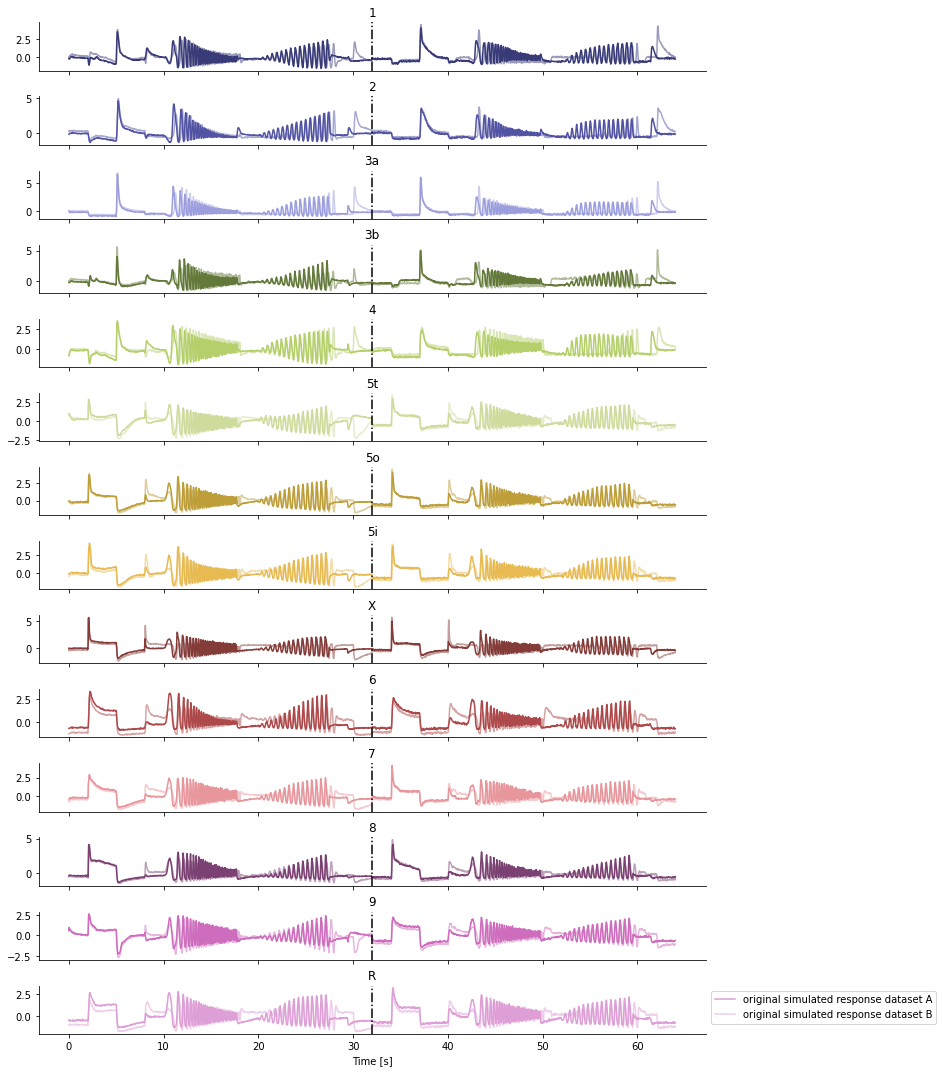

In [11]:
fig, axes = plt.subplots(14, figsize=(10, 15), sharex=True)
n_frames = sim_dataset.X_test.shape[-1]
temp_res = 30
total_dur = n_frames/temp_res
time_line = np.linspace(0, total_dur, n_frames)
mid = total_dur/2
for t in range(14):
    type_bool_mask = y_type_test_gt[sim_dataset.Y_scan_test==0]==t
    axes[t].plot(time_line,
        sim_dataset.X_test[sim_dataset.Y_scan_test==0][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=1, label="original simulated response dataset A"
        
    )
    
    type_bool_mask = y_type_test_gt[sim_dataset.Y_scan_test==1]==t
    axes[t].plot(time_line,
        sim_dataset.X_test[sim_dataset.Y_scan_test==1][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=0.5, label="original simulated response dataset B"
        
    )
    axes[t].set_title(type_names[t])
    axes[t].axvline(x=mid, linestyle="-.", color="k")
    
plt.xlabel("Time [s]")
sns.despine()
plt.tight_layout(h_pad=.5)
plt.legend(bbox_to_anchor=[1, 1])


# load model and training parameters

In [12]:
with open(your_path_to_params_file, "rb") as f:
    params = pkl5.load(f)

In [13]:
params

{'datatype': 'sim',
 'data_dir': '/gpfs01/euler/data/Resources/Classifier/data_post_submission/',
 'model_type': 'hybrid',
 'model_architecture': 'v2',
 'model': {'projection': None,
  'num_scans': 2,
  'num_types': 14,
  'num_hidden': 42,
  'dropout': 0.041384149756995295,
  'num_layer_scan_classifier': 2},
 'training': {'log_dir': '',
  'log_steps': 10,
  'num_iter': 5000,
  'dis_warm_cool_steps': 0,
  'weight_mse': 1.15368688968573,
  'weight_type': 1.2560989793855488,
  'weight_decay': 0.0019658529177110024,
  'weight_scan': 1,
  'lr_model': 2.554314385431982e-05,
  'lr_discriminator': 0.002629006617508444,
  'train_model_every': 8,
  'split': 0,
  'optimizer': 'adam'},
 'cell_type': 'bc'}

# Update params to be compatible with training v1

In [14]:
config = deepcopy(params)

In [15]:
config_update = {
    "datatype":"sim",
    "data_dir" : your_data_directory,
    "dataset_fname" : your_dataset_file_name,
    "model_type": "hybrid",
    "model_architecture": "autoencoder"}


In [16]:
config.update(config_update)

In [17]:
config["training"]["batch_size"] = 20160
config["training"]["reconstruction_loss"] = "torch.nn.functional.mse_loss"
config["training"]["type_classification_loss"] = "torch.nn.functional.cross_entropy"
config["training"]["domain_classification_loss"] = "torch.nn.functional.cross_entropy"
config["training"]["batched_training"] = False
config["training"]["optim_step_count"] = 1

# Load model and ... 

In [18]:
model = Autoencoder(sim_dataset.D, **config["model"])

### ... instantiate with state dict from checkpoint

In [20]:
with open(os.path.join(your_path_to_model_directory, "model.pth"), "rb") as f:
    state_dict = torch.load(f)
model.load_state_dict(state_dict)

<All keys matched successfully>

### ... or train again

In [ ]:
#model = train_model(config)

In [22]:
model_output = ModelOutputs()
model_output.get_model_outputs(model, sim_dataset)

In [23]:
num_hidden = params["model"]["num_hidden"]
print(num_hidden)

42


In [24]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1920, out_features=256, bias=False)
      (1): ResidualLayerV2(
        (layer): Sequential(
          (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Dropout(p=0.041384149756995295, inplace=False)
          (3): Linear(in_features=256, out_features=128, bias=False)
          (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Dropout(p=0.041384149756995295, inplace=False)
          (7): Linear(in_features=128, out_features=128, bias=False)
        )
      )
      (2): ResidualLayerV2(
        (layer): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Dropout(p=0.041384149756995295, inplace=False)
          (3): Linear(in_features=128, ou

# Visualize ... 

### ... reconstructions

#### for dataset A

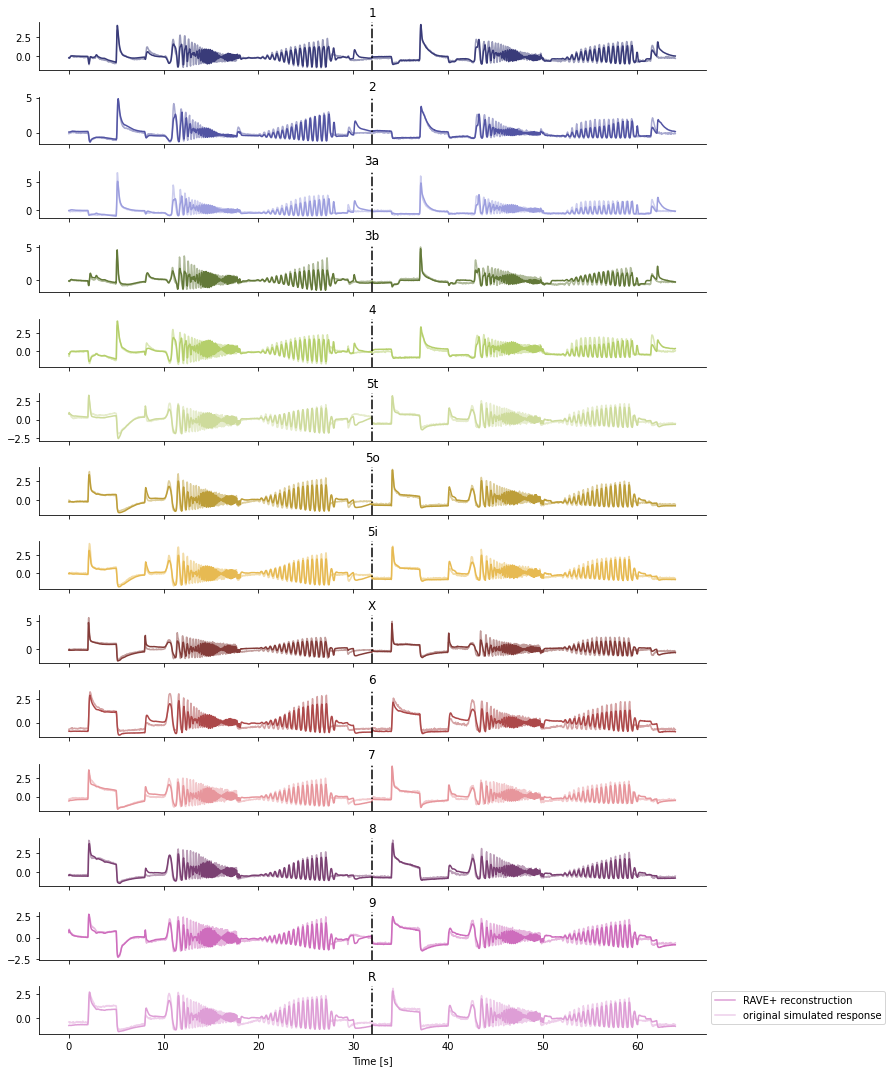

In [26]:
fig, axes = plt.subplots(14, figsize=(10, 15), sharex=True)
n_frames = sim_dataset.X_test.shape[-1]
temp_res = 30
total_dur = n_frames/temp_res
time_line = np.linspace(0, total_dur, n_frames)
mid = total_dur/2
for t in range(14):
    type_bool_mask = y_type_test_gt[sim_dataset.Y_scan_test==0]==t
    axes[t].plot(time_line,
        model_output.x_rec_test[sim_dataset.Y_scan_test==0][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), label="RAVE+ reconstruction"
    )
    axes[t].plot(time_line,
        sim_dataset.X_test[sim_dataset.Y_scan_test==0][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=0.5, label="original simulated response"
        
    )
    axes[t].set_title(type_names[t])
    axes[t].axvline(x=mid, linestyle="-.", color="k")
    
plt.xlabel("Time [s]")
sns.despine()
plt.tight_layout(h_pad=.5)
plt.legend(bbox_to_anchor=[1, 1])


#### for dataset B

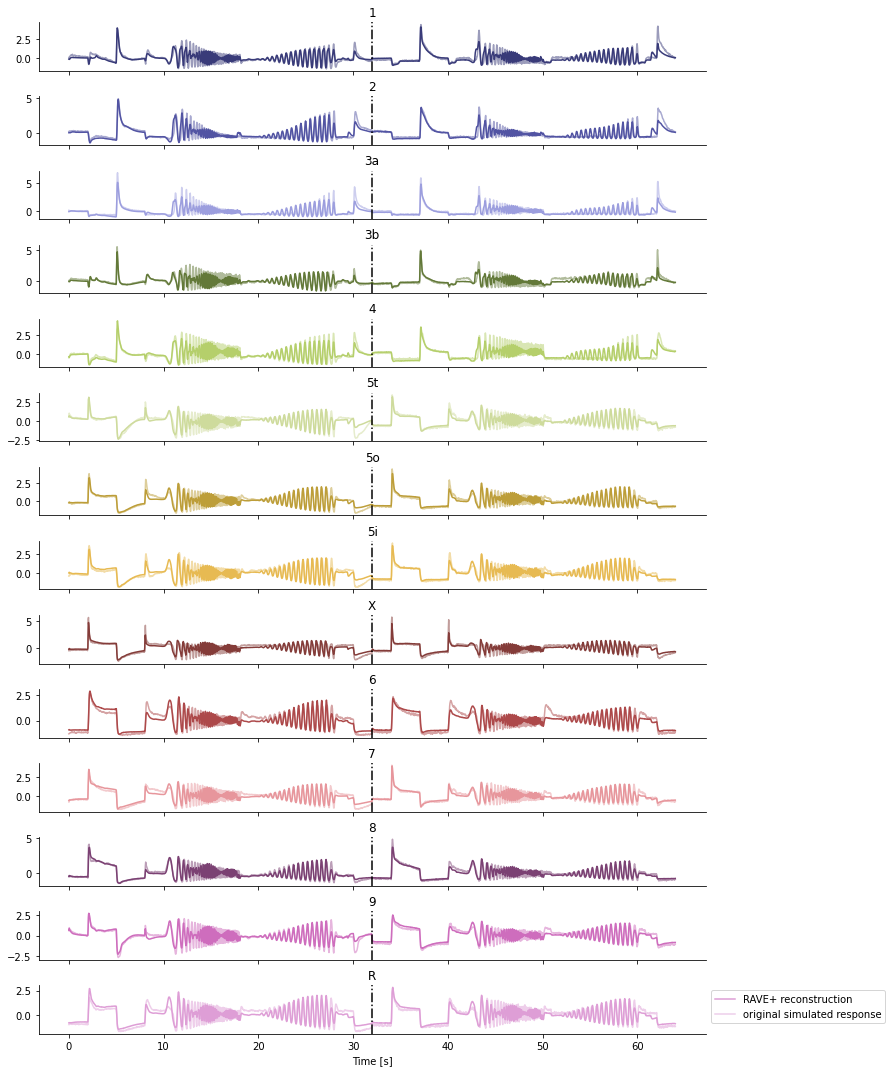

In [27]:
fig, axes = plt.subplots(14, figsize=(10, 15), sharex=True)
n_frames = sim_dataset.X_test.shape[-1]
temp_res = 30
total_dur = n_frames/temp_res
time_line = np.linspace(0, total_dur, n_frames)
mid = total_dur/2
for t in range(14):
    type_bool_mask = y_type_test_gt[sim_dataset.Y_scan_test==1]==t
    axes[t].plot(time_line,
        model_output.x_rec_test[sim_dataset.Y_scan_test==1][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), label="RAVE+ reconstruction"
    )
    axes[t].plot(time_line,
        sim_dataset.X_test[sim_dataset.Y_scan_test==1][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=0.5, label="original simulated response"
        
    )
    axes[t].set_title(type_names[t])
    axes[t].axvline(x=mid, linestyle="-.", color="k")
    
plt.xlabel("Time [s]")
sns.despine()
plt.tight_layout(h_pad=.5)
plt.legend(bbox_to_anchor=[1, 1])


#### datasets A and B jointly

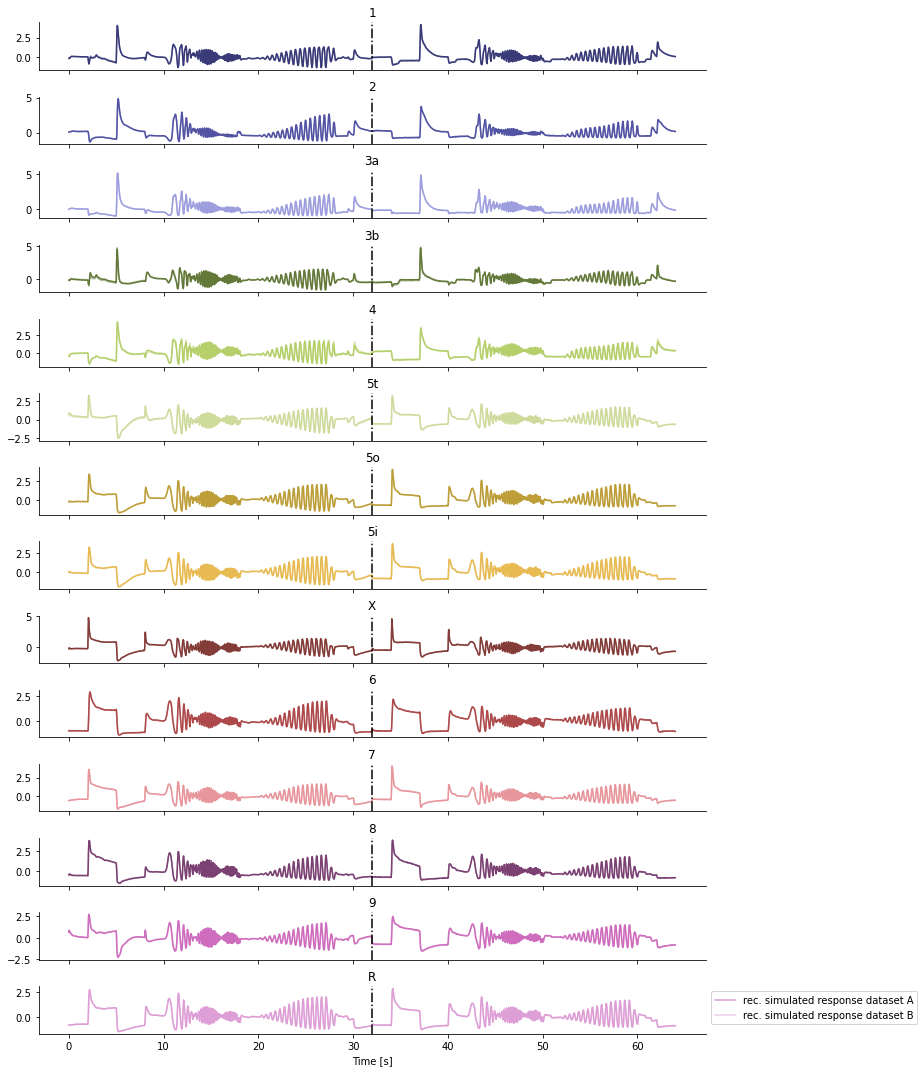

In [28]:
fig, axes = plt.subplots(14, figsize=(10, 15), sharex=True)
n_frames = sim_dataset.X_test.shape[-1]
temp_res = 30
total_dur = n_frames/temp_res
time_line = np.linspace(0, total_dur, n_frames)
mid = total_dur/2
for t in range(14):
    type_bool_mask = y_type_test_gt[sim_dataset.Y_scan_test==0]==t
    axes[t].plot(time_line,
        model_output.x_rec_test[sim_dataset.Y_scan_test==0][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=1, label="rec. simulated response dataset A"
        
    )
    
    type_bool_mask = y_type_test_gt[sim_dataset.Y_scan_test==1]==t
    axes[t].plot(time_line,
        model_output.x_rec_test[sim_dataset.Y_scan_test==1][type_bool_mask].mean(axis=0), 
        color=sc_map.to_rgba(t), alpha=0.5, label="rec. simulated response dataset B"
        
    )
    axes[t].set_title(type_names[t])
    axes[t].axvline(x=mid, linestyle="-.", color="k")
    
plt.xlabel("Time [s]")
sns.despine()
plt.tight_layout(h_pad=.5)
plt.legend(bbox_to_anchor=[1, 1])


### ... learned latent representations

In [29]:
embedding, embedder = get_embedding(model_output.z_test, embedding_type="tsne",
                                   embedding_kwargs=dict(initialization="pca", perplexity=20,
                                                                                            verbose=True))

--------------------------------------------------------------------------------
TSNE(perplexity=20, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 60 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.97 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.18 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=233.33 for 250 iterations...
Iteration   50, KL divergence 3.3977, 50 iterations in 0.8510 sec
Iteration  100, KL divergence 2.7652, 50 iterations in 0.7293 sec
Iteration  150, KL divergence 2.6018, 50 iterations in 0.7253 sec
Iteration  200, KL divergence 2.5231, 50 iterations in 0.7234 sec
Iteration  250, KL divergence 2.4755, 50 iterations in 0.7182 sec
   --> Time elapsed: 3.75 seconds
===> Running optimization with exaggeration=1.00, lr=233.33 for 

(<Figure size 360x720 with 4 Axes>,
 TSNEEmbedding([[-12.5299755 ,   1.20484765],
                [ 16.87051046,  -4.0336482 ],
                [ -7.97597732,  53.55589201],
                ...,
                [  0.24025244,  27.64130926],
                [ -6.69041926,  56.87049429],
                [-27.13752701,  24.56465906]]),
 TSNE(perplexity=20, random_state=42, verbose=True))

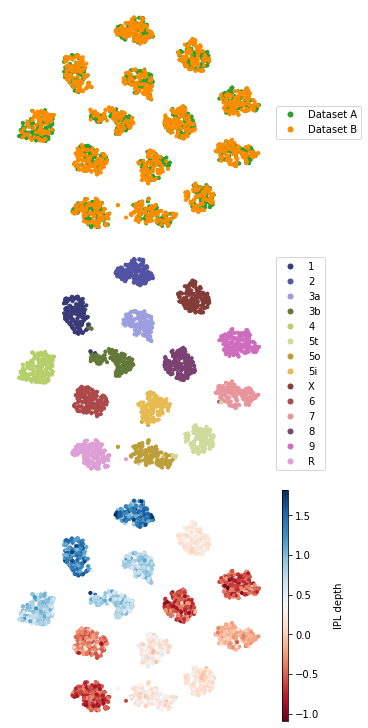

In [30]:
visualize_embedding_basic(model, sim_dataset, datatier="test",
                          embedder=embedder, embedding=embedding
                    )

# run evaluation on PCA-transformed, raw data

## get PCA transform of raw data

In [31]:
pca_obj = PCA(n_components=num_hidden, whiten=True)
pca_train = pca_obj.fit_transform(x_train)

In [34]:
result_dict_raw, output_pre = get_all_scores(sim_dataset, pca_train, pca_obj.transform(x_val),
                            pca_obj.transform(sim_dataset.X_test), y_scan_train, y_scan_val,
                            sim_dataset.Y_scan_test,
                       y_type_train, y_type_val, sim_dataset.Y_type_test, 
                        sim_dataset.ipl_depth_test,
                                             n_jobs=1,
                        conf_weighted_kde_estimate=True, correct_label_mixup=False,
                                            ipl_file1=ipl_file1,
                                            ipl_file2=ipl_file2)

start grid search
sklearn grid search identified best scan RFC parameters: 
 {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 20, 'random_state': 2021}
val set accuracy: 1.000
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 20, 'random_state': 1}
scan train score seed 0: 1.000
Best achieved test set scan accuracy 
 1.0
sklearn grid search identified best type RFC parameters: 
 {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'max_samples': 0.7, 'n_estimators': 30, 'random_state': 2021}
type train score seed 0: 1.000
Best achieved test set type accuracy 
 0.9821428571428571
True
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


In [35]:
print_result_dictionary(result_dict_raw, sim_dataset)

Mean +- sd domain accuracy: 1.00 +- 0.000
Mean +- sd type accuracy for dataset 0: 0.98 +- 0.000
type accuracy for dataset 1: 0.23
Mean +- SD; min JS for dataset 1 per type 
:
1:  0.613 +- 0.00; 0.613
2:  0.113 +- 0.00; 0.113
3a:  0.435 +- 0.00; 0.435
3b:  0.664 +- 0.00; 0.664
4:  0.619 +- 0.00; 0.619
5t:  0.597 +- 0.00; 0.597
5o:  0.547 +- 0.00; 0.547
5i:  0.156 +- 0.00; 0.156
X:  0.639 +- 0.00; 0.639
6:  0.335 +- 0.00; 0.335
7:  0.474 +- 0.00; 0.474
8:  0.238 +- 0.00; 0.238
9:  0.379 +- 0.00; 0.379
R:  0.492 +- 0.00; 0.492
domain accuracy: 1.00 +- 0.000
Mean +- SD ari cross for dataset 1 (consistency between cell typelabels assigned by 10 different type clfs): nan +- nan


/gpfs01/euler/User/lhoefling/GitHub/rave/rave/evaluation/utils.py:43: RuntimeWarning: Mean of empty slice.
  result_dictionary["ari_cross"].mean(), result_dictionary["ari_cross"].std()))
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# evaluate model: domain classification, type classification

In [36]:
[x_train, y_scan_train, x_val, y_scan_val, y_type_train,
         y_type_val] = sim_dataset.get_split(0, "cpu")

In [37]:
result_dict_rave, output = get_all_scores(sim_dataset, model_output.z_train,
              model_output.z_val,
              model_output.z_test,
              y_scan_train, y_scan_val, 
              sim_dataset.Y_scan_test,
              y_type_train, y_type_val,
              sim_dataset.Y_type_test,
               sim_dataset.ipl_depth_test,
                n_jobs=1,
                ppath = None, 
                conf_weighted_kde_estimate=True,
                correct_label_mixup=False,
                 ipl_file1=ipl_file1,
                 ipl_file2=ipl_file2
              )

start grid search
sklearn grid search identified best scan RFC parameters: 
 {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'max_samples': 0.9, 'n_estimators': 30, 'random_state': 2021}
val set accuracy: 0.662
{'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'max_samples': 0.9, 'n_estimators': 30, 'random_state': 1}
scan train score seed 0: 0.981
Best achieved test set scan accuracy 
 0.6546428571428572
sklearn grid search identified best type RFC parameters: 
 {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 15, 'max_samples': 0.9, 'n_estimators': 20, 'random_state': 2021}
type train score seed 0: 1.000
Best achieved test set type accuracy 
 0.9964285714285714
True
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


In [38]:
print_result_dictionary(result_dict_rave, sim_dataset)

Mean +- sd domain accuracy: 0.65 +- 0.000
Mean +- sd type accuracy for dataset 0: 1.00 +- 0.000
type accuracy for dataset 1: 0.98
Mean +- SD; min JS for dataset 1 per type 
:
1:  0.106 +- 0.00; 0.106
2:  0.075 +- 0.00; 0.075
3a:  0.043 +- 0.00; 0.043
3b:  0.070 +- 0.00; 0.070
4:  0.083 +- 0.00; 0.083
5t:  0.059 +- 0.00; 0.059
5o:  0.114 +- 0.00; 0.114
5i:  0.110 +- 0.00; 0.110
X:  0.086 +- 0.00; 0.086
6:  0.059 +- 0.00; 0.059
7:  0.061 +- 0.00; 0.061
8:  0.120 +- 0.00; 0.120
9:  0.103 +- 0.00; 0.103
R:  0.157 +- 0.00; 0.157
domain accuracy: 0.65 +- 0.000
Mean +- SD ari cross for dataset 1 (consistency between cell typelabels assigned by 10 different type clfs): nan +- nan


/gpfs01/euler/User/lhoefling/GitHub/rave/rave/evaluation/utils.py:43: RuntimeWarning: Mean of empty slice.
  result_dictionary["ari_cross"].mean(), result_dictionary["ari_cross"].std()))
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Perform IPL depth distribution analysis

In [39]:
from rave.evaluation.visualize import depth_dist_plots

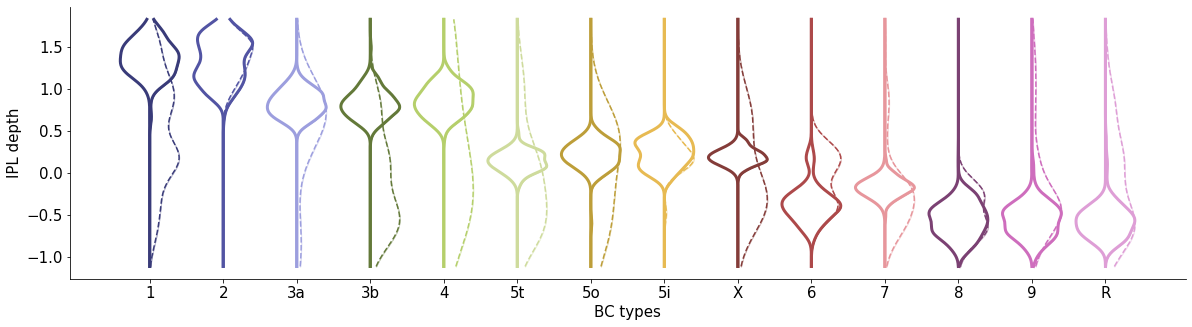

In [40]:
with mpl.rc_context({"font.size":15, "lines.linewidth" : 3}):
    depth_dist_plots(ipl_depth_per_type_em, 
                     res_dict=dict(kde_per_type=result_dict_rave["kde_per_type_all"]),
                     res_dict_raw=dict(kde_per_type=result_dict_raw["kde_per_type_all"]),
                     ipl_depth_em_dict=ipl_dict,
                     fname=""
                )